In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from utils import get_wallet
from portfolio_prices import get_portfolio_prices

In [84]:
def mount_wallet_data_frame(google_sheet_key: str) -> pd.DataFrame:
    
    wallet_items = get_wallet(google_sheet_key)
    
    wallet = pd.DataFrame(wallet_items).set_index('Date')
    
    wallet.index = pd.to_datetime(wallet.index, format = '%d/%m/%Y')
    
    return wallet

In [85]:
def get_assets_by_type(wallet, asset_type):
    
    asset_filter = wallet[wallet.asset_type == asset_type]
    
    assets = set(asset_filter.asset_name.to_list())
    
    return assets

In [86]:
def get_portfolio_performace(wallet):
    
    funds = get_assets_by_type(wallet, 'fund')
    stocks = get_assets_by_type(wallet, 'stock')
    etfs = get_assets_by_type(wallet, 'etf')
    
    allocations = wallet.pivot(columns = 'asset_name').value.fillna(0)
    
    portfolio_prices = get_portfolio_prices(stocks, funds, etfs, start_date='01/01/2018').asfreq('B')
    
    return portfolio_prices

In [87]:
def mount_wallet_shares(wallet, prices):
    
    wallet_shares = []
    
    for i in range(len(wallet)):
        
        asset_name = wallet.iloc[i].asset_name
        value = wallet.iloc[i].value
        date = wallet.index[i]
        
        shares = float(value) / prices[asset_name][date]
        
        wallet_shares.append(shares)
        
    wallet['shares'] = wallet_shares 
    
    for asset in wallet.asset_name.unique():
        
        wallet.loc[wallet.asset_name == asset, 'shares'] = wallet[wallet.asset_name == asset].shares.cumsum()
    
    return wallet

In [88]:
wallet = mount_wallet_data_frame('14KWHuqot8Fr74-Yw4x0brDDdSZDoQL7SBiN1Q5vL188')

In [89]:
portfolio_prices = get_portfolio_performace(wallet)
prices = portfolio_prices['Close']

In [90]:
shares = mount_wallet_shares(wallet, prices)

In [91]:
shares

,asset_type,asset_name,value,shares
Date,,,,
2020-09-15,stock,PETR4,1000,46.146747
2021-04-07,stock,LAME4,1000,45.065345
2020-12-17,stock,CIEL3,100,26.385224
2020-09-15,stock,BBDC4,1000,49.726504


In [92]:
def get_allocation_time_series(wallet):
    
    allocations = wallet.pivot(columns = 'asset_name').shares.asfreq('B')
    
    last_date = allocations.index[-1]
    
    df = pd.DataFrame(pd.date_range(start=last_date, end='2021-04-09', freq='B'))
    df.columns = ['Date']
    
    allocations = allocations.merge(df, on='Date', how='outer').set_index('Date')
    
    allocations = allocations.fillna(method='ffill').astype(np.float64).asfreq('B')
    
    return allocations

In [93]:
allocations = get_allocation_time_series(shares)

In [94]:
allocations

,BBDC4,CIEL3,LAME4,PETR4
Date,,,,
2020-09-15,49.726504,NaN,NaN,46.146747
2020-09-16,49.726504,NaN,NaN,46.146747
2020-09-17,49.726504,NaN,NaN,46.146747
2020-09-18,49.726504,NaN,NaN,46.146747
2020-09-21,49.726504,NaN,NaN,46.146747
...,...,...,...,...
2021-04-05,49.726504,26.385224,NaN,46.146747
2021-04-06,49.726504,26.385224,NaN,46.146747
2021-04-07,49.726504,26.385224,45.065345,46.146747


In [95]:
def get_portfolio(prices, allocations):
    
    portfolio = (prices.loc[:, allocations.columns] * allocations).asfreq('B').fillna(method='ffill')
    
    return portfolio

def get_patrimony(portfolio):
    
    patrimony = portfolio.sum(axis=1)
    
    return patrimony

In [96]:
portfolio = get_portfolio(prices, allocations)

<AxesSubplot:xlabel='Date'>

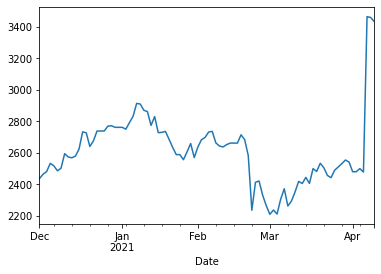

In [97]:
get_patrimony(portfolio).loc['2020-12':].plot()

In [98]:
def get_returns(prices, portfolio):
    
    weights = portfolio.div(portfolio.sum(axis=1), axis=0).fillna(0)
    
    returns = pd.DataFrame(index = weights.index)
    returns['Returns'] = 0

    for time in weights.index:
        returns['Returns'].loc[time] = np.dot(prices.pct_change().loc[time], weights.loc[time])
        
    return returns

<AxesSubplot:xlabel='Date'>

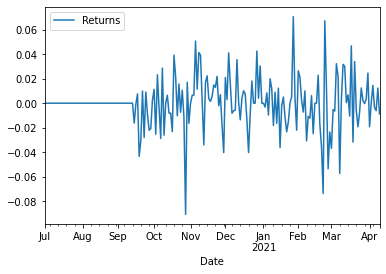

In [99]:
get_returns(prices, portfolio).loc['2020-07':].plot()

In [100]:
def get_cumulative_returns(prices, portfolio):
    
    returns = get_returns(prices, portfolio)
                          
    cumulative_returns = (1 + returns).cumprod()
                          
    return cumulative_returns

<AxesSubplot:xlabel='Date'>

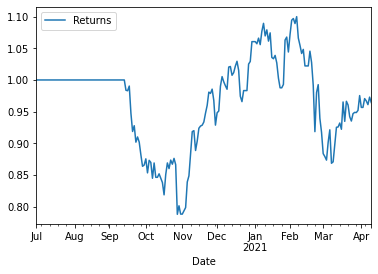

In [101]:
get_cumulative_returns(prices, portfolio).loc['2020-07':].plot()